# Image Data Pre processing (I hate you guys)

In [5]:
!pip install opendatasets
!pip install tensorflow
!pip install transformers
!pip install datasets
!pip install pandas
!pip install sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post11-py3-none-any.whl size=2959 sha256=9e8ef397731d4c5668739751febcd9c12474d033a3ff7eee99036c770fbbdc14
  Stored in directory: /root/.cache/pip/wheels/aa/9c/60/f67813603a52fc35057868f1aba0003cc75b72583dcaa2c341
Successfully built sklearn


In [6]:
from pathlib import Path
from datasets import Dataset, ClassLabel, Image
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tqdm import tqdm
import gc
import os
import opendatasets as od
import pandas as pd
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile, Image
import matplotlib.pyplot as plt

In [7]:
# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Constants for image size and batch size
IMG_SIZE = (64, 64)  # Example size, adjust as needed
BATCH_SIZE = 32

# Function to load and preprocess image
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0  # Normalize to [0,1]
    return image

In [8]:
od.download(
    "https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images")

# Base directory path of your dataset in Google Drive
base_dir = '/content/deepfake-and-real-images/Dataset'  # Update with your path

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nicolasrr749
Your Kaggle Key: ··········


100%|██████████| 1.68G/1.68G [01:15<00:00, 24.0MB/s]


In [9]:
# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Iterate through all image files in the specified directory
for file in sorted((Path(base_dir).glob('*/*/*.*'))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Print the total number of file names and labels
print(len(file_names), len(labels))

190335 190335


In [10]:
# Create a pandas dataframe from file names and labels
df = pd.DataFrame({"image": file_names, "label": labels})

# Random Oversampling
ros = RandomOverSampler(random_state=83)
df_resampled, labels_resampled = ros.fit_resample(df[['image']], df['label'])

# Update DataFrame with resampled data
df = pd.DataFrame({"image": df_resampled['image'], "label": labels_resampled})

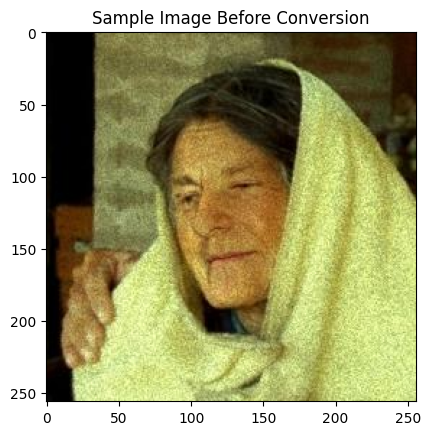

In [11]:
# Select a sample image from the DataFrame
sample_image_path = df['image'].iloc[0]

# Load and display the sample image
sample_image = Image.open(sample_image_path)
plt.imshow(sample_image)
plt.title("Sample Image Before Conversion")
plt.show()

In [12]:
# Convert labels from string to integer
label2id = {'Real': 0, 'Fake': 1}
df['label'] = df['label'].apply(lambda x: label2id[x])

In [13]:
# Perform the train-test split
train_df, test_df = train_test_split(df, test_size=0.05, stratify=df['label'])

In [14]:
# Convert the DataFrames to TensorFlow datasets
def df_to_dataset(dataframe, shuffle=True, batch_size=32, prefetch=True):
    dataframe = dataframe.copy()
    labels = dataframe.pop('label')
    ds = tf.data.Dataset.from_tensor_slices((dataframe['image'].values, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.map(lambda x, y: (load_and_preprocess_image(x), y)).batch(batch_size)
    if prefetch:
        ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Convert to TensorFlow datasets
train_data = df_to_dataset(train_df, batch_size=BATCH_SIZE)
test_data = df_to_dataset(test_df, batch_size=BATCH_SIZE)

# Garbage collection
gc.collect()

3286

Numerical Tensor Representation of the Image:
 [[[0.19411765 0.20784314 0.10196079]
  [0.20784314 0.23137255 0.12058824]
  [0.29509804 0.3019608  0.15490197]
  ...
  [0.82941175 0.7705882  0.65686274]
  [0.827451   0.76862746 0.654902  ]
  [0.827451   0.76862746 0.654902  ]]

 [[0.26078433 0.26960784 0.1254902 ]
  [0.26078433 0.27450982 0.11666667]
  [0.39117646 0.39117646 0.20196079]
  ...
  [0.7019608  0.6431373  0.5294118 ]
  [0.6911765  0.63235295 0.51862746]
  [0.6901961  0.6313726  0.5176471 ]]

 [[0.21176471 0.19607843 0.13529412]
  [0.22745098 0.2        0.11568628]
  [0.2529412  0.22941177 0.12058824]
  ...
  [0.74019605 0.6813725  0.56764704]
  [0.72156864 0.6627451  0.54901963]
  [0.7235294  0.6647059  0.5509804 ]]

 ...

 [[0.6372549  0.45490196 0.37058824]
  [0.6        0.42156863 0.29607844]
  [0.8098039  0.627451   0.4745098 ]
  ...
  [0.23921569 0.23921569 0.23137255]
  [0.22745098 0.22745098 0.22745098]
  [0.18627451 0.18627451 0.19411765]]

 [[0.77254903 0.5862745  0.

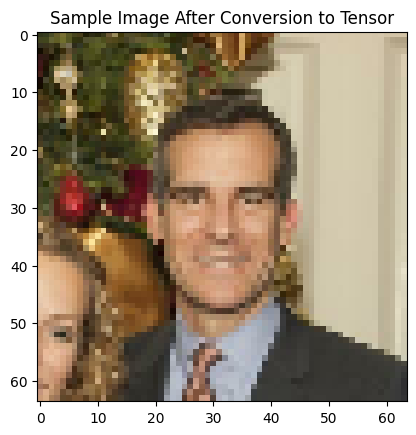

In [15]:
# Take one batch from the dataset
for images, labels in train_data.take(1):
    # Extract the first image tensor from the batch
    tensor_image = images[0]

    print(f"Numerical Tensor Representation of the Image:\n {tensor_image}\n")

    # Convert the tensor to a numpy array and display it
    plt.imshow(tensor_image.numpy())
    plt.title("Sample Image After Conversion to Tensor")
    plt.show()

    # Break the loop after the first batch
    break

# Fully Connected Deep Neural Network

In [16]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=IMG_SIZE + (3,)),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
    return model

### Mini training just to see if data works

In [17]:
# Create the model
model = create_model()

# Quick Training
# We will train on a small subset of data for a few epochs just to ensure the model is working.

# Assuming 'train_data' and 'test_data' are already defined TensorFlow datasets
# as per your previous setup.

# Take a subset for quick training
train_subset = train_data.take(100)  # Adjust the number based on your dataset size
test_subset = test_data.take(20)    # Adjust the number based on your dataset size

# Train the model
history = model.fit(train_subset, epochs=5, validation_data=test_subset)

Epoch 1/5
100/100 [==============================] - 11s 11ms/step - loss: 0.8059 - accuracy: 0.5400 - auc: 0.5508 - precision: 0.5505 - recall: 0.5819 - val_loss: 0.6817 - val_accuracy: 0.5875 - val_auc: 0.6454 - val_precision: 0.7403 - val_recall: 0.3373
Epoch 2/5
100/100 [==============================] - 1s 7ms/step - loss: 0.7363 - accuracy: 0.5431 - auc: 0.5559 - precision: 0.5241 - recall: 0.5432 - val_loss: 0.6616 - val_accuracy: 0.6281 - val_auc: 0.6692 - val_precision: 0.7384 - val_recall: 0.3969
Epoch 3/5
100/100 [==============================] - 1s 7ms/step - loss: 0.6853 - accuracy: 0.5756 - auc: 0.6140 - precision: 0.5626 - recall: 0.6042 - val_loss: 0.6394 - val_accuracy: 0.6484 - val_auc: 0.7052 - val_precision: 0.6601 - val_recall: 0.6211
Epoch 4/5
100/100 [==============================] - 1s 7ms/step - loss: 0.6725 - accuracy: 0.5800 - auc: 0.6252 - precision: 0.5728 - recall: 0.6420 - val_loss: 0.6303 - val_accuracy: 0.6125 - val_auc: 0.7411 - val_precision: 0.5663

### The complete stratified K-Fold ☠️☠️☠️

In [18]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef
import json
import pickle

In [19]:
# Constants
N_SPLITS = 5
EPOCHS = 200  # Adjust as needed

# Prepare data for Stratified K-Fold
labels = df['label'].values
skf = StratifiedKFold(n_splits=N_SPLITS)

# Initialize metrics
all_metrics = {
    'ACC': [],
    'AUC': [],
    'PRE': [],
    'REC': [],
    'F1': [],
    'MCC': [],
    'Loss': []
}

In [20]:
# Directory to save models and results
save_dir = '/content/checkpoints/'
os.makedirs(save_dir, exist_ok=True)

# Stratified K-Fold Cross-Validation
for fold, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f'Fold {fold+1}/{N_SPLITS}')

    # Split the dataset
    train_fold_df = df.iloc[train_idx]
    test_fold_df = df.iloc[test_idx]

    train_data_fold = df_to_dataset(train_fold_df, batch_size=BATCH_SIZE)
    test_data_fold = df_to_dataset(test_fold_df, batch_size=BATCH_SIZE)

    # Create model
    model = create_model()

    with tf.device('/GPU:0'):
      # Model checkpoint callback
      checkpoint = tf.keras.callbacks.ModelCheckpoint(
          'model_fold_{}.h5'.format(fold+1),
          save_best_only=True,
          monitor='val_loss',
          mode='min'
      )

      # Train the model
      history = model.fit(train_data_fold, epochs=EPOCHS, validation_data=test_data_fold, callbacks=[checkpoint])

      # Save the model
      model_path = os.path.join(save_dir, f'model_fold_{fold+1}.h5')
      model.save(model_path)
      print(f"Model saved at {model_path}")

      # Save training history
      history_path = os.path.join(save_dir, f'history_fold_{fold+1}.json')
      with open(history_path, 'w') as f:
          json.dump(history.history, f)
      print(f"Training history saved at {history_path}")

      # Evaluate the model
      metrics = model.evaluate(test_data_fold)
      all_metrics['ACC'].append(metrics[1])
      all_metrics['AUC'].append(metrics[2])
      all_metrics['PRE'].append(metrics[3])
      all_metrics['REC'].append(metrics[4])
      # Compute F1 and MCC
      predictions = model.predict(test_data_fold)
      f1 = f1_score(test_fold_df['label'], np.round(predictions))
      mcc = matthews_corrcoef(test_fold_df['label'], np.round(predictions))
      all_metrics['F1'].append(f1)
      all_metrics['MCC'].append(mcc)
      all_metrics['Loss'].append(metrics[0])

Fold 1/5
Epoch 1/200
4761/4761 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.6806 - auc: 0.7474 - precision: 0.7003 - recall: 0.6316

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4761/4761 [==============================] - 32s 6ms/step - loss: 0.5888 - accuracy: 0.6806 - auc: 0.7474 - precision: 0.7003 - recall: 0.6316 - val_loss: 0.5581 - val_accuracy: 0.7067 - val_auc: 0.7889 - val_precision: 0.6792 - val_recall: 0.7833
Epoch 2/200
4761/4761 [==============================] - 30s 6ms/step - loss: 0.5378 - accuracy: 0.7240 - auc: 0.8008 - precision: 0.7407 - recall: 0.6893 - val_loss: 0.5389 - val_accuracy: 0.7278 - val_auc: 0.8110 - val_precision: 0.7935 - val_recall: 0.6160
Epoch 3/200
4761/4761 [==============================] - 30s 6ms/step - loss: 0.5237 - accuracy: 0.7327 - auc: 0.8127 - precision: 0.7455 - recall: 0.7066 - val_loss: 0.5341 - val_accuracy: 0.7364 - val_auc: 0.8153 - val_precision: 0.7626 - val_recall: 0.6865
Epoch 4/200
4761/4761 [==============================] - 30s 6ms/step - loss: 0.5136 - accuracy: 0.7416 - auc: 0.8216 - precision: 0.7521 - recall: 0.7209 - val_loss: 0.5205 - val_accuracy: 0.7432 - val_auc: 0.8234 - val_precision: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4761/4761 [==============================] - 30s 6ms/step - loss: 0.6038 - accuracy: 0.6690 - auc: 0.7292 - precision: 0.6881 - recall: 0.6183 - val_loss: 0.5555 - val_accuracy: 0.7200 - val_auc: 0.8124 - val_precision: 0.6944 - val_recall: 0.7861
Epoch 2/200
4761/4761 [==============================] - 29s 6ms/step - loss: 0.5532 - accuracy: 0.7136 - auc: 0.7856 - precision: 0.7284 - recall: 0.6812 - val_loss: 0.5070 - val_accuracy: 0.7517 - val_auc: 0.8405 - val_precision: 0.7273 - val_recall: 0.8054
Epoch 3/200
4761/4761 [==============================] - 28s 6ms/step - loss: 0.5405 - accuracy: 0.7232 - auc: 0.7980 - precision: 0.7324 - recall: 0.7034 - val_loss: 0.5018 - val_accuracy: 0.7583 - val_auc: 0.8464 - val_precision: 0.8182 - val_recall: 0.6642
Epoch 4/200
4761/4761 [==============================] - 28s 6ms/step - loss: 0.5284 - accuracy: 0.7337 - auc: 0.8090 - precision: 0.7414 - recall: 0.7177 - val_loss: 0.4933 - val_accuracy: 0.7681 - val_auc: 0.8535 - val_precision: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4761/4761 [==============================] - 30s 6ms/step - loss: 0.6053 - accuracy: 0.6677 - auc: 0.7280 - precision: 0.6856 - recall: 0.6196 - val_loss: 0.5210 - val_accuracy: 0.7507 - val_auc: 0.8389 - val_precision: 0.7401 - val_recall: 0.7728
Epoch 2/200
4761/4761 [==============================] - 28s 6ms/step - loss: 0.5569 - accuracy: 0.7099 - auc: 0.7827 - precision: 0.7200 - recall: 0.6868 - val_loss: 0.5135 - val_accuracy: 0.7728 - val_auc: 0.8579 - val_precision: 0.8405 - val_recall: 0.6733
Epoch 3/200
4761/4761 [==============================] - 28s 6ms/step - loss: 0.5431 - accuracy: 0.7207 - auc: 0.7957 - precision: 0.7286 - recall: 0.7035 - val_loss: 0.4721 - val_accuracy: 0.7812 - val_auc: 0.8649 - val_precision: 0.7857 - val_recall: 0.7733
Epoch 4/200
4761/4761 [==============================] - 28s 6ms/step - loss: 0.5340 - accuracy: 0.7271 - auc: 0.8044 - precision: 0.7332 - recall: 0.7141 - val_loss: 0.4923 - val_accuracy: 0.7907 - val_auc: 0.8740 - val_precision: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4761/4761 [==============================] - 30s 6ms/step - loss: 0.5858 - accuracy: 0.6838 - auc: 0.7487 - precision: 0.7082 - recall: 0.6252 - val_loss: 0.5457 - val_accuracy: 0.7233 - val_auc: 0.8040 - val_precision: 0.7703 - val_recall: 0.6366
Epoch 2/200
4761/4761 [==============================] - 28s 6ms/step - loss: 0.5437 - accuracy: 0.7167 - auc: 0.7924 - precision: 0.7452 - recall: 0.6584 - val_loss: 0.5519 - val_accuracy: 0.7138 - val_auc: 0.8113 - val_precision: 0.8169 - val_recall: 0.5512
Epoch 3/200
4761/4761 [==============================] - 28s 6ms/step - loss: 0.5286 - accuracy: 0.7284 - auc: 0.8071 - precision: 0.7514 - recall: 0.6826 - val_loss: 0.5319 - val_accuracy: 0.7314 - val_auc: 0.8191 - val_precision: 0.7933 - val_recall: 0.6258
Epoch 4/200
4761/4761 [==============================] - 28s 6ms/step - loss: 0.5171 - accuracy: 0.7365 - auc: 0.8168 - precision: 0.7559 - recall: 0.6987 - val_loss: 0.5217 - val_accuracy: 0.7496 - val_auc: 0.8298 - val_precision: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4761/4761 [==============================] - 30s 6ms/step - loss: 0.5889 - accuracy: 0.6782 - auc: 0.7446 - precision: 0.7025 - recall: 0.6182 - val_loss: 0.5709 - val_accuracy: 0.6916 - val_auc: 0.7720 - val_precision: 0.7345 - val_recall: 0.6003
Epoch 2/200
4761/4761 [==============================] - 28s 6ms/step - loss: 0.5389 - accuracy: 0.7218 - auc: 0.7978 - precision: 0.7441 - recall: 0.6761 - val_loss: 0.5633 - val_accuracy: 0.6995 - val_auc: 0.7923 - val_precision: 0.7708 - val_recall: 0.5679
Epoch 3/200
4761/4761 [==============================] - 28s 6ms/step - loss: 0.5235 - accuracy: 0.7354 - auc: 0.8120 - precision: 0.7525 - recall: 0.7016 - val_loss: 0.5383 - val_accuracy: 0.7303 - val_auc: 0.8098 - val_precision: 0.7591 - val_recall: 0.6748
Epoch 4/200
4761/4761 [==============================] - 28s 6ms/step - loss: 0.5123 - accuracy: 0.7431 - auc: 0.8213 - precision: 0.7581 - recall: 0.7141 - val_loss: 0.5447 - val_accuracy: 0.7309 - val_auc: 0.8142 - val_precision: 

In [21]:
# Calculate mean and standard deviation for each metric
for metric in all_metrics.keys():
    mean_value = np.mean(all_metrics[metric])
    std_dev = np.std(all_metrics[metric])
    print(f'{metric} Mean: {mean_value}, Std Dev: {std_dev}')

# Save overall metrics
overall_metrics_path = os.path.join(save_dir, 'overall_metrics.json')
with open(overall_metrics_path, 'w') as f:
    json.dump({metric: {'mean': np.mean(all_metrics[metric]), 'std_dev': np.std(all_metrics[metric])} for metric in all_metrics}, f)
print(f"Overall metrics saved at {overall_metrics_path}")

# Function to plot metrics
def plot_metrics(history, metric, val_metric, title, ylabel, save_path):
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(save_path)
    plt.show()

ACC Mean: 0.7579805612564087, Std Dev: 0.018901792663124778
AUC Mean: 0.8878282904624939, Std Dev: 0.015795777978643528
PRE Mean: 0.9117239236831665, Std Dev: 0.020155247836450185
REC Mean: 0.5712444424629212, Std Dev: 0.03293052168878102
F1 Mean: 0.38481333896903547, Std Dev: 0.01173189122552688
MCC Mean: -0.0002430173135040033, Std Dev: 0.006535877238461517
Loss Mean: 0.48064773678779604, Std Dev: 0.0316138042944156
Overall metrics saved at /content/checkpoints/overall_metrics.json


1190/1190 [==============================] - 3s 3ms/step


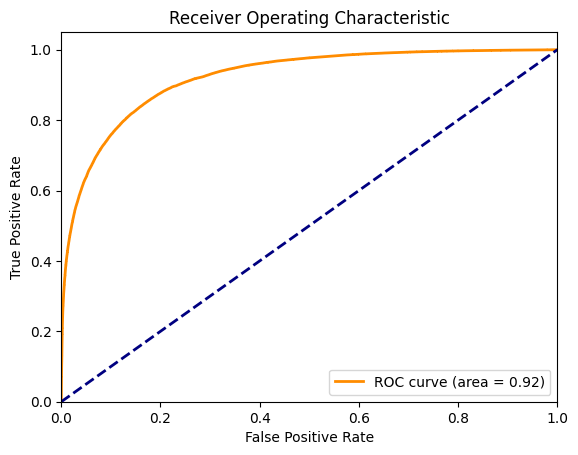

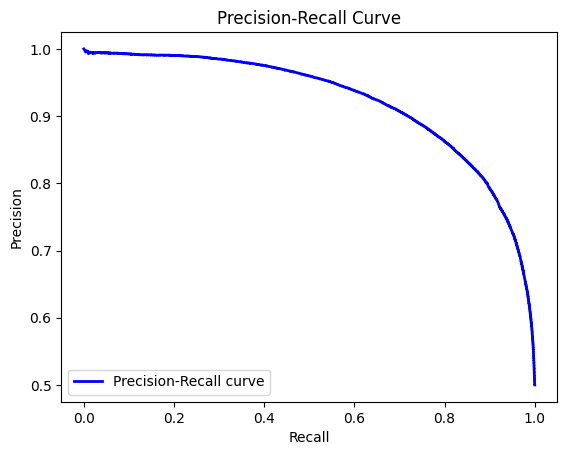

In [22]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Arrays to store true labels and predictions
true_labels = []
predicted_scores = []

# Collect predictions and true labels from each fold
for fold in range(1, N_SPLITS + 1):
    # Load the best model for this fold
    model_path = os.path.join(save_dir, f'model_fold_{fold}.h5')
    model = tf.keras.models.load_model(model_path)

    # Get the test data for this fold
    test_fold_df = df.iloc[test_idx]
    test_data_fold = df_to_dataset(test_fold_df, batch_size=BATCH_SIZE, shuffle=False)

    # Make predictions
    predictions = model.predict(test_data_fold)
    predicted_scores.extend(predictions.flatten())

    # Store true labels
    true_labels.extend(test_fold_df['label'].values)

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_scores = np.array(predicted_scores)

# Generate ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
roc_curve_path = os.path.join(save_dir, 'roc_curve.png')
plt.savefig(roc_curve_path)
plt.show()

# Generate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, predicted_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
pr_curve_path = os.path.join(save_dir, 'precision_recall_curve.png')
plt.savefig(pr_curve_path)
plt.show()